In [2]:
import pandas as pd
import polars as pl
import duckdb as db
import numpy as np
import scipy.stats as st

from ucimlrepo import fetch_ucirepo 
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import adjusted_rand_score, silhouette_score, normalized_mutual_info_score, rand_score, adjusted_mutual_info_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.spatial.distance import pdist, squareform

import os
import xml.etree.ElementTree as ET
from tqdm import tqdm

import time
import matplotlib.pyplot as plt
import seaborn as sns

from urllib.request import urlopen
import xmltodict

from itertools import combinations
from collections import Counter


# HW2

Overall rules:

- Do not split your answers into separate files. All answers must be in a single jupyter notebook. 
- Refrain from downloading and loading data from a local file unless specifically specified. Obtain all required remote data using the appropriate API.
- Refrain from cleaning data by hand on a spreadsheet. All cleaning must be done programmatically, with each step explained. This is so that I can replicate the procedure deterministically.
- Refrain from using code comments to explain what has been done. Document your steps by writing appropriate markdown cells in your notebook.
- Avoid duplicating code by copying and pasting it from one cell to another. If copying and pasting is necessary, develop a suitable function for the task at hand and call that function.
- When providing parameters to a function, never use global variables. Instead, always pass parameters explicitly and always make use of local variables.
- Document your use of LLM models (ChatGPT, Claude, Code Pilot etc). Either take screenshots of your steps and include them with this notebook, or give me a full log (both questions and answers) in a markdown file named HW2-LLM-LOG.md.

Failure to adhere to these guidelines will result in a 15-point deduction for each infraction.

## Atabey's Notes

- Q1: The analysis part looks ok. However, I can't see where you record the time. Did you do it by hand? Also, there is an issue of "confidence intervals". The values you calculate are single. Are you sure about their accuracy? 80
- Q2: Looks good. But you should get the full picture: accuracy, recall, precision, and F1-score. 100
- Q3: Very good. It would been nicer if you also plotted chi-square results over the years. 100
- Q4: You are repeating code here. You didn't have to pull the data for everytime you did an analysis. Lazy. Otherwise looks good. 80

Overall: 90

## Q1

For this question we are going to use [RT-IoT2022](https://archive.ics.uci.edu/dataset/942/rt-iot2022) dataset from [UCI](https://archive.ics.uci.edu/). We have seen several clustering algorithms, and also some measures of quality for clusters in the lectures. Use all you have learned and compare the clustering algorithms we have learnt using the quality measures we have seen in the class.  You must write a detailed comparison analysis to evaluate which model behaves better based on the results you will obtain. One part of your analysis should also include how much time it takes to train and run the models.

In [2]:
rt_iot2022 = fetch_ucirepo(id=942) 
  
X = rt_iot2022.data.features 
y = rt_iot2022.data.targets 

features_encoded = pd.get_dummies(X)

X_all = features_encoded
y_all = y.squeeze()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

In [3]:
def degerlendirme(labels, y_all, X_scaled):
    ri = rand_score(y_all, labels)
    silhouette = silhouette_score(X_scaled, labels)
    mi = adjusted_mutual_info_score(y_all, labels)

    print(f"Rand Index: {ri:.4f}")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Mutual Information: {mi:.4f}")
    

In [4]:
kmeans = KMeans(n_clusters=len(y_all.unique()), random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

print("KMeans")
degerlendirme(labels_km, y_all, X_scaled)

KMeans
Rand Index: 0.7037
Silhouette Score: 0.4400
Mutual Information: 0.5417


In [5]:
agg = AgglomerativeClustering(n_clusters=len(y_all.unique()), linkage='single')
labels_hier = agg.fit_predict(X_scaled)

print("Hierarchical")
degerlendirme(labels_hier, y_all, X_scaled)

Hierarchical
Rand Index: 0.6019
Silhouette Score: 0.9686
Mutual Information: 0.0009


In [7]:
dbscan = DBSCAN(eps=1.5, min_samples=6)
labels_db = dbscan.fit_predict(X_scaled)

print("DBScan")
degerlendirme(labels_db, y_all, X_scaled)

DBScan
Rand Index: 0.6801
Silhouette Score: 0.6391
Mutual Information: 0.6499


Bu veri seti bir makine √∂ƒürenmesi uygulamasƒ± setidir ve i√ßeriƒüinde aƒü saldƒ±rƒ±larƒ± vardƒ±r. Veri setinde aƒü trafiƒüi ile ilgili bilgiler vardƒ±r ve target s√ºtununda yani Attack_Type s√ºtununda ise bu trafik sonucunda ger√ßekle≈üen eylemin normal bir eylem mi olduƒüu yoksa bir saldƒ±rƒ± mƒ± olduƒüu, eƒüer saldƒ±rƒ± ise hangi t√ºr olduƒüuna dair bilgiler vardƒ±r. 

Soruda bizden derste g√∂r√ºlen k√ºmeleme algoritmalarƒ±nƒ±n kullanƒ±lmasƒ± isteniyor. Bu algoritmalar KMeans, Hierarchical ve DBSCAN algoritmalarƒ±dƒ±r. 
KMeans algoritmasƒ± verileri belirli sayƒ±da k√ºmelere ayƒ±rƒ±r ve her k√ºmenin merkezini bulur. Daha sonrasƒ±nda ise diƒüer veri noktalarƒ± kendisine en yakƒ±n olan merkez noktasƒ±na g√∂re k√ºmelenir. 
Hierarchical algoritmasƒ±nda veriler hep birlikte bir k√ºmeden ba≈ülar ve daha sonrasƒ±nda √∂zelliklerine g√∂re farklƒ± k√ºmelere ayrƒ±lƒ±rlar ya da birle≈ütirilirler.
DBSCAN algoritmasƒ±nda ise veri noktalarƒ±nƒ±n yoƒüun olduƒüu b√∂lgeler k√ºme olarak tanƒ±mlanƒ±r. 

Veri setimizde bu algoritmalarƒ± kullanarak √ßalƒ±≈ütƒ±ƒüƒ±mƒ±zda ise yukarƒ±daki gibi sonu√ßlar elde ettik. 
 Soruda istendiƒüi gibi derste √∂ƒürenilen √∂l√ß√ºm y√∂ntemleri olan Rand Index, Silhouette Score ve Mutual Information y√∂ntemlerini kullandƒ±m.
Bu y√∂ntemlerden Rand Index bizim yaptƒ±ƒüƒ±mƒ±z tahminlere g√∂re olu≈üturulan k√ºmelerin, ger√ßek deƒüerlerle kar≈üƒ±la≈ütƒ±rarak ne kadar doƒüru tahmin ettiƒüimizi √∂l√ßer.
Silhouette Score y√∂ntemi bir k√ºmedeki veri noktasƒ±nƒ±n, aynƒ± k√ºmedeki diƒüer veri noktalarƒ±yla ne kadar benzer √∂zelliklerde olduƒüunu √∂l√ßer ve bunun sonucunu verir.
Mutual Information y√∂ntemi ise bizim yaptƒ±ƒüƒ±mƒ±z tahminlere g√∂re olu≈üturulan k√ºmelerin, ger√ßek deƒüerlerle ne kadar uyumlu olduƒüunu g√∂sterir.

Algoritmalarƒ±mƒ±zƒ±n doƒüruluk deƒüerleri a≈üaƒüƒ±daki gibidir:

| Performans                | KMeans       |Hierarchical |DBSCAN|
|---------------------------|--------------|-------------|------|
| Rand Index                | 0.7037       |0.6019       |0.6801|
| Silhouette Score          | 0.4400       |0.9686       |0.6391|
| Mutual Information        | 0.5417       |0.0009       |0.6499|

Algoritmalar neredeyse benzer sonu√ßlar verdi ancak Hierarchical metodunun Mutual Information √∂l√ß√ºm√ºn√ºn √ßok d√º≈ü√ºk √ßƒ±kmasƒ± bu metodu kullanmamamƒ±za sebep oldu. Bu metodun Silhouette Score'unun √ßok iyi olmasƒ± yani aynƒ± k√ºmedeki veri noktalarƒ±nƒ±n birbirine √ßok benzer olmasƒ± bu metodu √∂ne √ßƒ±karƒ±rken diƒüer √∂l√ß√ºm y√∂nteminin k√∂t√º sonu√ß vermesi bu metodu elememize sebep oldu. Diƒüer iki algoritma kar≈üƒ±la≈ütƒ±rƒ±ldƒ±ƒüƒ±nda ise DBSCAN algoritmasƒ± daha iyi sonu√ßlar verdi. Bu y√ºzden tercih sebebi olabilir ancak tercih edeceƒüimiz algoritmanƒ±n √ßalƒ±≈üma s√ºrelerini de dikkate almamƒ±z bizim i√ßin daha faydalƒ± olur. Algoritmalarƒ±n √ßalƒ±≈üma s√ºreleri ise a≈üaƒüƒ±daki gibidir.

| Algoritma             | S√ºre   |
|-----------------------|------  |
| KMeans                | 3 dakika 40 saniye|
| Hierarchical          | 21 dakika 8 saniye|
| DBSCAN                | 45 dakika 17 saniye|

Bu tabloya g√∂re KMeans ile DBSCAN arasƒ±nda yakla≈üƒ±k 15 katlƒ±k bir fark bulunmakta ve KMeans daha hƒ±zlƒ± √ßalƒ±≈ümaktadƒ±r. Burada √∂nemli olan zamanƒ±n mƒ± yoksa performansƒ±n mƒ± bizim i√ßin daha √∂nemli olduƒüudur. 

S√ºreler arasƒ±nda ciddi farklar olmasƒ±ndan dolayƒ± ben KMeans algoritmasƒ±nƒ± kullanmayƒ± tercih ettim. 


## Q2

For this question we are going to use MNIST digits dataset. We have analyzed 3 classification algorithms so far. These are

1. K-NN
2. SVM
3. Logistric Regression

Use these algorithms to obtain 3 classification models on the dataset. Then use an appropriate cross-validation scheme to test the quality of the models and compare. You must write a detailed comparison analysis to evaluate which model behaves better based on the results you will obtain. One part of your analysis should also include how much time it takes to train and run the models.

‚è± K-NN i√ßin zaman √∂l√ß√ºm√º ba≈ülatƒ±ldƒ±...



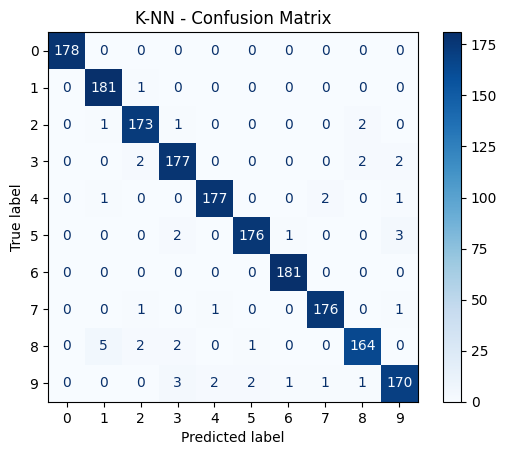

‚è± SVM i√ßin zaman √∂l√ß√ºm√º ba≈ülatƒ±ldƒ±...



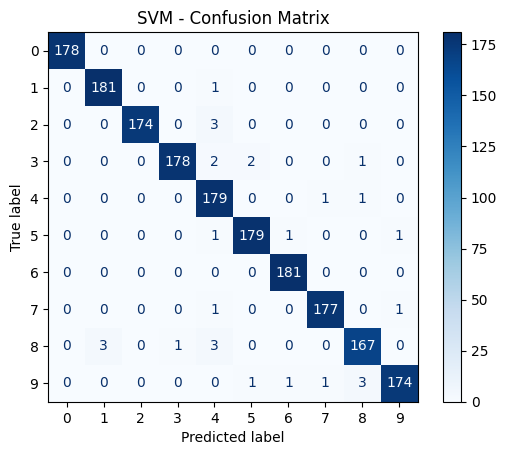

‚è± Logistic Regression i√ßin zaman √∂l√ß√ºm√º ba≈ülatƒ±ldƒ±...



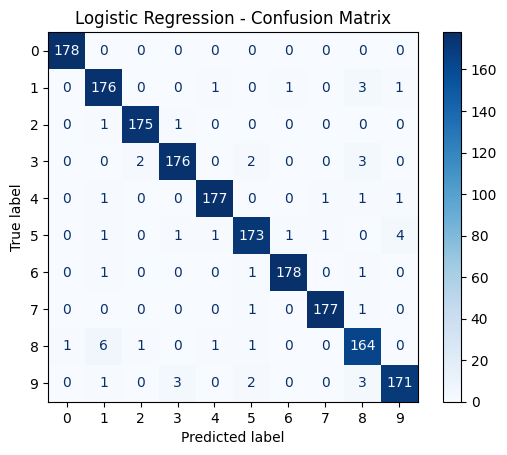

üìä Genel Performans ve Zaman Metrikleri:
                     Accuracy  Precision (macro)  Recall (macro)  \
K-NN                   0.9755             0.9756          0.9754   
SVM                    0.9839             0.9841          0.9838   
Logistic Regression    0.9711             0.9711          0.9711   

                     F1-score (macro)  F1-score (micro)  Time (s)  
K-NN                           0.9754            0.9755    2.3367  
SVM                            0.9839            0.9839    0.2663  
Logistic Regression            0.9711            0.9711    0.1038  


In [9]:
digits = load_digits()
X = digits.data
y = digits.target

models = {
    "K-NN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3)),
    "SVM": make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='scale')),
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial'))
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    print(f"‚è± {name} i√ßin zaman √∂l√ß√ºm√º ba≈ülatƒ±ldƒ±...\n")
    
    start_time = time.time()
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
    end_time = time.time()
    
    elapsed_time = end_time - start_time

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='macro')
    rec = recall_score(y, y_pred, average='macro')
    f1_macro = f1_score(y, y_pred, average='macro')
    f1_micro = f1_score(y, y_pred, average='micro')
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
    
    results[name] = {
        "Accuracy": acc,
        "Precision (macro)": prec,
        "Recall (macro)": rec,
        "F1-score (macro)": f1_macro,
        "F1-score (micro)": f1_micro,
        "Time (s)": elapsed_time
    }

df_results = pd.DataFrame(results).T
print("üìä Genel Performans ve Zaman Metrikleri:")
print(df_results.round(4))


MNIST basamak seti makine √∂ƒürenimi ve g√∂r√ºnt√º i≈üleme alanlarƒ±nda kullanƒ±lan bir veri setidir. Bu veri seti daha √ßok antrenman yapmak amacƒ±yla kullanƒ±lƒ±r. G√∂rece daha basit bir veri setidir. 
Algoritmalarƒ±mƒ±zda ise K-NN y√∂ntemi en yakƒ±n kom≈üusuna bakarak bir veri noktasƒ±nƒ± k√ºmelemeye ve sƒ±nƒ±flandƒ±rmaya √ßalƒ±≈üƒ±r. Sƒ±nƒ±flandƒ±rƒ±lacak verimiz en √ßok uyu≈ütuƒüu diƒüer noktalarla aynƒ± k√ºmeye konularak sƒ±nƒ±flandƒ±rƒ±lƒ±r. K deƒüerimiz en yakƒ±n ka√ß kom≈üuya bakƒ±lacaƒüƒ±nƒ± belirtir.
SVM y√∂ntemi ise farklƒ± sƒ±nƒ±flardaki √∂rnekler arasƒ±ndaki mesafeyi maksimize eder ve bu mesafe arasƒ±nda bir karar noktasƒ± bulur. Daha sonrasƒ±nda ise bu noktaya g√∂re sƒ±nƒ±flarƒ± tanƒ±mlar. 
Lojistik regresyon y√∂nteminde ise diƒüer bilgilerden yola √ßƒ±karak bir veri noktasƒ±nƒ±n hangi sƒ±nƒ±fta olduƒüu tahmin edilir ve buna g√∂re veri noktalarƒ± sƒ±nƒ±flara ayrƒ±lƒ±r. 

Veri setimizde bu y√∂ntemleri kullanarak √ßalƒ±≈ütƒ±ƒüƒ±mƒ±zda ise yukarƒ±daki gibi sonu√ßlar elde ettik. 
Modellerimiz arasƒ±ndan en ba≈üarƒ±lƒ± tahmin oranƒ±na ula≈üan model SVM modeli oldu. SVM modeli diƒüer modellere g√∂re Accuracy metriƒüinde yani yapƒ±lan doƒüru tahminlerin t√ºm tahminlere oranƒ±nda, Precision metriƒüinde yani modelin bir sƒ±nƒ±fa koyduƒüu verilere ne kadar g√ºvenebileceƒüimizi belirleyen metrikte, Recall metriƒüinde yani modelin ger√ßek deƒüerin ne kadarƒ±nƒ± doƒüru olarak tahmin ettiƒüini g√∂steren metrikte, F1-Score metriƒüinde yani Precision ile Recall deƒüerlerinden yola √ßƒ±karak bir hesaplama yapan metrikte √∂ndedir. B√ºt√ºn metriklerde 1 deƒüerine yakƒ±n olma durumu daha iyi performans anlamƒ±na gelir. Confusion Matrix'te de √ßakƒ±≈üan(√ñrn. satƒ±rda 1, s√ºtunda 1) h√ºcre sayƒ±sƒ± modelimizin bize ba≈üarƒ±sƒ±nƒ± g√∂sterir. Burada da SVM rakiplerine g√∂re daha y√ºksek bir √ßakƒ±≈üma oranƒ± elde etmi≈ütir.
Bu durum bize SVM modelinin diƒüer modellere g√∂re daha iyi sonu√ßlar verdiƒüini g√∂sterir.

Ancak durumu bir de zaman bakƒ±mƒ±ndan ele almak gerekir. Bizim veri setimiz g√∂rece basit bir set olduƒüu i√ßin √ßok kƒ±sa s√ºrelerde sonu√ß alabiliyoruz. Daha karƒ±≈üƒ±k ve b√ºy√ºk veri setine denk geldiƒüimizde ise s√ºre bizim a√ßƒ±mƒ±zdan √∂nemli hale gelebilir. Modellerin s√ºrelerine baktƒ±ƒüƒ±mƒ±zda K-NN modeli 2.33 saniyede, SVM modeli 0.24 saniyede, Lojistik Regresyon modeli ise 0.11 saniyede √ßalƒ±≈ümƒ±≈ütƒ±r. 

Bu veri seti √ºzerinde SVM ile K-NN kar≈üƒ±la≈ütƒ±rdƒ±ƒüƒ±mƒ±zda SVM hem performans olarak hem de s√ºre olarak daha uyumlu bir modeldir. SVM ile Lojistik Regresyon'u kar≈üƒ±la≈ütƒ±rdƒ±ƒüƒ±mƒ±zda ise aralarƒ±nda yakla≈üƒ±k 2 katlƒ±k bir zaman farkƒ± vardƒ±r. SVM daha iyi performans vermesine raƒümen daha yava≈ü √ßalƒ±≈ümƒ±≈ütƒ±r. Burada √∂nemli olan zamanƒ±n mƒ± yoksa performansƒ±n mƒ± bizim i√ßin daha √∂nemli olduƒüudur. 

S√ºreler √ßok kƒ±sa olduƒüu i√ßin ben SVM modelini kullanmayƒ± tercih etiim.

## Q3

For this homework, we are going to use the [data warehouse](https://clerk.house.gov/Votes/) for the [US House of Representatives](https://www.house.gov/). The data server has data on each vote going back to 1990. The voting information is in XML format. For example, the code below pulls the data for the 71st roll call from 2024 Congress.

1. Obtain all of the data from 2010 to 2024 (inclusive, all years, all calls). You may save a local copy, and push the local copy onto your github repo.
2. Construct a similarity measure function for a pair of legislators. The function should return the number of times both legislators voted the same way and the number of sessions both attended.
3. Find the legislators whose voting records are the most similar to: (i) Matt Gaetz and (ii) Alexandria Ocasio-Cortez.
4. Using this similarity measure, do a hiearchical clustering for legislators, and analyze the result.
5. Construct a function that takes a year as an input and returns a 2x2 table couting the number of times Democrats voted with other Democrats, the number of times Democrats voted with Republicans, the number of times Republicans voted with Democrats, and the number of times Republicans voted with other Republicans in that year.
6. Analyze the table for each year since 2010 using the $\chi^2$-statistic, and evaluate the polarization in the House of representatives. In this context, explain what a lower or higher $\chi^2$-metric means. Explain whether the polarization in the House of representatives increased or decreased over the years?

In [ ]:
def get_voting_data(year, roll_call):
    url = f'https://clerk.house.gov/evs/{year}/roll{roll_call:03}.xml'
    try:
        with urlopen(url) as response:
            raw = xmltodict.parse(response.read())
            return raw
    except Exception as e:
        print(f"Hata: {url} adresinden veri alƒ±namadƒ±. Hata mesajƒ±: {e}")
        return None

def save_data_to_file(data, year, roll_call):
    if data:
        filename = f'data/{year}/roll{roll_call:03}.xml'
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(xmltodict.unparse(data, pretty=True))
        print(f"{filename} dosyasƒ±na kaydedildi.")

years = range(2010, 2025)
for year in years:
    roll_call = 1
    while True:
        data = get_voting_data(year, roll_call)
        if data is None:
            break
        save_data_to_file(data, year, roll_call)
        roll_call += 1

print("Veri toplama ve kaydetme i≈ülemi tamamlandƒ±.")

In [51]:
def parse_vote_xml(file_path):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()

        metadata = root.find("vote-metadata")
        rollcall_num = metadata.find("rollcall-num").text
        vote_question = metadata.find("vote-question").text
        vote_result = metadata.find("vote-result").text
        vote_date = metadata.find("action-date").text
        vote_time = metadata.find("action-time").text
        vote_type = metadata.find("vote-type").text
        vote_desc = metadata.find("vote-desc").text

        vote_data = []
        for vote in root.find("vote-data").findall("recorded-vote"):
            legislator = vote.find("legislator")
            vote_choice = vote.find("vote").text

            vote_data.append({
                "id": legislator.attrib.get("name-id"),
                "name": legislator.text,
                "party": legislator.attrib.get("party"),
                "state": legislator.attrib.get("state"),
                "vote": vote_choice,
                "rollcall": rollcall_num,
                "vote_date": vote_date,
            })

        return vote_data
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return []

base_dir = r"C:\Class\MYZ309E\HW2\data"

all_xml_files = []
for year_folder in os.listdir(base_dir):
    year_path = os.path.join(base_dir, year_folder)
    if os.path.isdir(year_path):
        for file in os.listdir(year_path):
            if file.endswith(".xml"):
                all_xml_files.append(os.path.join(year_path, file))

all_votes = []
for xml_file in tqdm(all_xml_files, desc="XML Dosyalarƒ± ƒ∞≈üleniyor"):
    vote_records = parse_vote_xml(xml_file)
    all_votes.extend(vote_records)

df_all_votes = pd.DataFrame(all_votes)

df_all_votes


XML Dosyalarƒ± ƒ∞≈üleniyor: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9207/9207 [00:43<00:00, 211.14it/s]


id         name party state        vote rollcall    vote_date
0        A000014  Abercrombie     D    HI  Not Voting        1  12-Jan-2010
1        A000022     Ackerman     D    NY     Present        1  12-Jan-2010
2        A000055     Aderholt     R    AL  Not Voting        1  12-Jan-2010
3        A000364   Adler (NJ)     D    NJ     Present        1  12-Jan-2010
4        A000358         Akin     R    MO  Not Voting        1  12-Jan-2010
...          ...          ...   ...   ...         ...      ...          ...
3977312  W000795  Wilson (SC)     R    SC         Yea      517  20-Dec-2024
3977313  W000804      Wittman     R    VA         Yea      517  20-Dec-2024
3977314  W000809       Womack     R    AR         Yea      517  20-Dec-2024
3977315  Y000067        Yakym     R    IN         Yea      517  20-Dec-2024
3977316  Z000018        Zinke     R    MT         Yea      517  20-Dec-2024

[3977317 rows x 7 columns]

In [52]:
valid_votes = ['Yea', 'Aye', 'Nay', 'No']
df_filtered_votes = df_all_votes[df_all_votes["vote"].isin(valid_votes)]

valid_party= ['D', 'R']
df_filtered_votes = df_filtered_votes[df_filtered_votes["party"].isin(valid_party)]

name_mapping = (
    df_filtered_votes.groupby("id")["name"]
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)
df_filtered_votes["name"] = df_filtered_votes["id"].map(name_mapping)

df_filtered_votes["year"] = df_filtered_votes["vote_date"].apply(lambda x: x.split("-")[2])
df_filtered_votes["year_rollcall"] = df_filtered_votes["year"] + "_" + df_filtered_votes["rollcall"].astype(str)

vote_matrix = df_filtered_votes.pivot_table(
    index="year_rollcall", columns="id", values="vote", aggfunc="first"
)


In [53]:
def similarity(legislator_id1, legislator_id2):
    v1 = vote_matrix[legislator_id1]
    v2 = vote_matrix[legislator_id2]

    mask = v1.notna() & v2.notna()
    common_sessions_count = mask.sum()

    same_votes_count = (v1[mask] == v2[mask]).sum()

    return same_votes_count, common_sessions_count

def similarity_ratio(legislator_id1, legislator_id2):
    same, total = similarity(legislator_id1, legislator_id2)
    return same / total if total > 0 else None

def similarity_score(id1, id2):
    v1 = vote_matrix[id1]
    v2 = vote_matrix[id2]
    mask = v1.notna() & v2.notna()
    total = mask.sum()
    same = (v1[mask] == v2[mask]).sum()
    return same / total if total > 0 else 0

def find_most_similar(target_id, top_n=5):
    scores = []
    for other_id in vote_matrix.columns:
        if other_id != target_id:
            score = similarity_score(target_id, other_id)
            scores.append((other_id, score))
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:top_n]

similarity("I000023", "A000055")

(np.int64(542), np.int64(569))

In [54]:
similarity_ratio("I000023", "A000055")

np.float64(0.9525483304042179)

In [55]:
gaetz_id = df_filtered_votes[df_filtered_votes["name"].str.contains("Gaetz", case=False, na=False)]["id"].unique()
aoc_id = df_filtered_votes[df_filtered_votes["name"].str.contains("Ocasio", case=False, na=False)]["id"].unique()

print("Matt Gaetz ID:", gaetz_id)
print("AOC ID:", aoc_id)
id_to_name = df_filtered_votes.set_index("id")["name"].to_dict()

gaetz_top_matches = find_most_similar(gaetz_id[0])
print("\nMatt Gaetz'e en √ßok benzeyenler:")
for uid, score in gaetz_top_matches:
    print(f"{id_to_name.get(uid, 'Bilinmeyen')} ({uid}): {score:.2%}")

aoc_top_matches = find_most_similar(aoc_id[0])
print("\nAlexandria Ocasio-Cortez'e en √ßok benzeyenler:")
for uid, score in aoc_top_matches:
    print(f"{id_to_name.get(uid, 'Bilinmeyen')} ({uid}): {score:.2%}")



Matt Gaetz ID: ['G000578']
AOC ID: ['O000172']

Matt Gaetz'e en √ßok benzeyenler:
Mulvaney (M001182): 100.00%
Price (GA) (P000591): 100.00%
Chaffetz (C001076): 94.56%
DeSantis (D000621): 94.28%
Franks (AZ) (F000448): 94.19%

Alexandria Ocasio-Cortez'e en √ßok benzeyenler:
Lee (PA) (L000602): 99.15%
Ramirez (R000617): 98.96%
Bowman (B001223): 98.69%
Pressley (P000617): 98.48%
Lee Carter (L000605): 98.36%


In [ ]:
def fill_missing_votes_by_party_fast(X, df_filtered_votes):
    from collections import defaultdict

    id_to_party = df_filtered_votes.drop_duplicates("id").set_index("id")["party"].to_dict()

    party_majority_votes = defaultdict(dict)

    for col in X.columns:
        for party in ["D", "R"]:
            party_votes = X.loc[X["party"] == party, col]
            vote_counts = party_votes.value_counts()
            if not vote_counts.empty:
                party_majority_votes[col][party] = vote_counts.idxmax()

    filled_X = X.copy()
    for row_id in filled_X.index:
        party = id_to_party.get(row_id)
        if not party:
            continue
        for col in X.columns:
            if pd.isna(filled_X.at[row_id, col]):
                majority_vote = party_majority_votes.get(col, {}).get(party, None)
                if majority_vote is not None:
                    filled_X.at[row_id, col] = majority_vote

    return filled_X.drop(columns=["party"])


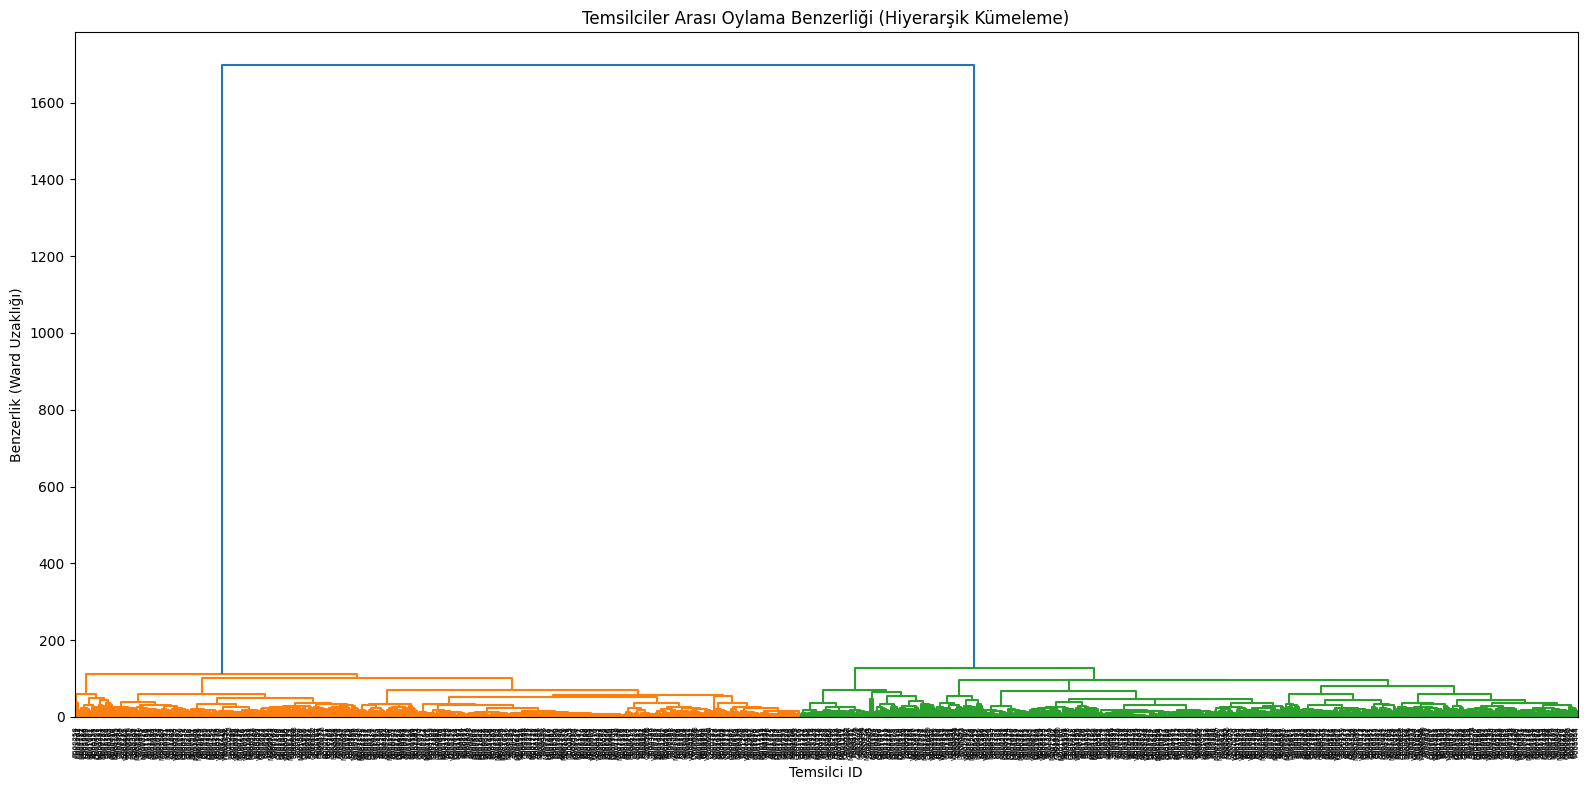

In [ ]:
vote_numeric = vote_matrix.replace({'Yea': 2, 'Aye': 2, 'Nay': 1, 'No': 1})
X = vote_numeric.T
X["party"] = X.index.map(lambda x: id_to_party.get(x))

X_filled = fill_missing_votes_by_party_fast(X, df_filtered_votes)

linkage_matrix = linkage(X_filled, method='ward')

plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, labels=X_filled.index.to_list(), leaf_rotation=90)
plt.title("Temsilciler Arasƒ± Oylama Benzerliƒüi (Hiyerar≈üik K√ºmeleme)")
plt.xlabel("Temsilci ID")
plt.ylabel("Benzerlik (Ward Uzaklƒ±ƒüƒ±)")
plt.tight_layout()
plt.show()

En temel seviyede milletvekillerini kapsayan b√ºy√ºk bir k√ºme var. Bu k√ºme benzer oy verme verilerine sahip olan milletvekillerini g√∂steriyor. Milletvekilleri muhtemelen en ba≈ütan aynƒ± k√ºmelere dahil oldular ve bu y√ºzden b√ºy√ºk bir sayƒ±yla aynƒ± k√ºmeye girdiler. Daha sonrasƒ±nda ise konular √∂zelle≈üti ve a≈üaƒüƒ±ya doƒüru inildik√ße ise k√ºme sayƒ±sƒ± artƒ±yor ve oy verme davranƒ±≈ülarƒ± √∂zelle≈ümeye ba≈ülƒ±yor.

In [ ]:
def party_agreement_ratio_table(year, df_filtered_votes):
    df_year = df_filtered_votes[df_filtered_votes["year"] == str(year)]

    vote_matrix = df_year.pivot_table(
        index="year_rollcall", columns="id", values="vote", aggfunc="first"
    )

    vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})
    vote_numeric = vote_numeric.dropna(how="all", axis=0)

    id_to_party = df_year.drop_duplicates("id").set_index("id")["party"].to_dict()

    agreement_counts = {
        ("D", "D"): [0, 0],
        ("D", "R"): [0, 0],
        ("R", "D"): [0, 0],
        ("R", "R"): [0, 0]
    }

    for _, row in vote_numeric.iterrows():
        valid_votes = row.dropna()
        for id1, vote1 in valid_votes.items():
            party1 = id_to_party.get(id1)
            if party1 not in ["D", "R"]:
                continue
            for id2, vote2 in valid_votes.items():
                party2 = id_to_party.get(id2)
                if party2 not in ["D", "R"] or id1 >= id2:
                    continue
                agreement_counts[(party1, party2)][1] += 1
                agreement_counts[(party2, party1)][1] += 1
                if vote1 == vote2:
                    agreement_counts[(party1, party2)][0] += 1
                    agreement_counts[(party2, party1)][0] += 1

    result_table = pd.DataFrame(
        {
            "Democrat": [
                agreement_counts[("D", "D")][0] / agreement_counts[("D", "D")][1] if agreement_counts[("D", "D")][1] > 0 else 0,
                agreement_counts[("R", "D")][0] / agreement_counts[("R", "D")][1] if agreement_counts[("R", "D")][1] > 0 else 0,
            ],
            "Republican": [
                agreement_counts[("D", "R")][0] / agreement_counts[("D", "R")][1] if agreement_counts[("D", "R")][1] > 0 else 0,
                agreement_counts[("R", "R")][0] / agreement_counts[("R", "R")][1] if agreement_counts[("R", "R")][1] > 0 else 0,
            ]
        },
        index=["Democrat", "Republican"]
    )

    return (result_table * 100).round(2)


In [68]:
party_agreement_ratio_table(2010, df_filtered_votes)


C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       93.71       61.53
Republican     61.53       92.98

In [70]:
party_agreement_ratio_table(2011, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat        84.7       29.00
Republican      29.0       88.33

In [71]:
party_agreement_ratio_table(2012, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       85.89       32.26
Republican     32.26       89.09

In [72]:
party_agreement_ratio_table(2013, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       86.84       34.17
Republican     34.17       90.19

In [73]:
party_agreement_ratio_table(2014, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       90.00       30.11
Republican     30.11       90.66

In [74]:
party_agreement_ratio_table(2015, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       91.64       27.76
Republican     27.76       89.50

In [75]:
party_agreement_ratio_table(2016, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       93.39       28.61
Republican     28.61       92.88

In [76]:
party_agreement_ratio_table(2017, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       93.35       26.76
Republican     26.76       92.81

In [77]:
party_agreement_ratio_table(2018, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       91.93       42.11
Republican     42.11       91.93

In [78]:
party_agreement_ratio_table(2019, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       96.64       33.91
Republican     33.91       86.87

In [79]:
party_agreement_ratio_table(2020, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       96.16       30.91
Republican     30.91       90.19

In [80]:
party_agreement_ratio_table(2021, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       97.82       35.87
Republican     35.87       89.85

In [81]:
party_agreement_ratio_table(2022, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       97.79       43.51
Republican     43.51       85.67

In [82]:
party_agreement_ratio_table(2023, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       95.13       28.45
Republican     28.45       86.30

In [83]:
party_agreement_ratio_table(2024, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


Democrat  Republican
Democrat       93.07       34.70
Republican     34.70       88.62

Bazƒ± yƒ±llarda verilen aynƒ± oy oranlarƒ± artƒ±≈ü g√∂sterse de genel olarak benzer seviyede reddetmi≈ü. Bu yƒ±llarda ABD politikasƒ±nda deƒüi≈üiklikler olmasƒ± bana √ßok muhtemel geldi. Genellikle √ºlkelerin g√ºvenlik problemleri olduƒüunda halk meclisten birlik i√ßinde davranmasƒ±nƒ± bekliyor veya bir g√ºvenlik tasarƒ±sƒ± s√∂z konusu olduƒüunda vekiller gelen baskƒ±lara direnemeyebiliyor. Bu y√ºzden de benzer oylar kullanƒ±yorlar. Aynƒ± oy kullanmalarƒ±nƒ±n sebepleri bu gibi nedenler olabilir. Bu nedenlerin arasƒ±nda √ßevre faaliyetleri, insan haklarƒ± problemleri, farklƒ± √ºlkelere y√∂nelik alƒ±nacak tedbirler, i√ß sorunlar da √∂rnek g√∂sterilebilir. Bu birka√ß yƒ±l haricinde ise oranlar %30 seviyelerinde daƒüƒ±lmƒ±≈ü yani benzerlik g√∂stermi≈ü. %30 benim beklediƒüimden y√ºksek √ßƒ±ktƒ± a√ßƒ±k√ßasƒ±. Ben daha ayrƒ±k, daha kutuplu bir meclis bekliyordum. Ama sonu√ß olarak vekillerin kendi partileri ile oy oranlarƒ±na kƒ±yasla kar≈üƒ±la≈ütƒ±rdƒ±ƒüƒ±mƒ±zda %30 √ßok d√º≈ü√ºk kalƒ±yor. Bu da partilerin birbirlerinin √∂nerilerini dinlememesinden kaynaklanabilir. Diƒüer sebep olarak da partiler genellikle halk yararƒ±na bir √∂neri geldiƒüinde √ßoƒüunluk olan partinin yaptƒ±ƒüƒ± bir ≈üey olarak g√∂z√ºkmesin diye reddedebiliyorlar. Ya da √ßoƒüunluk olan parti muhalefetin iyi yaptƒ±ƒüƒ± bir ≈üey olarak g√∂z√ºkmesin diye bu √∂neriyi reddedebiliyor. Bu gibi sebeplerden bu oy oranlarƒ± √ßƒ±kmƒ±≈ü olabilir. 

In [ ]:
from scipy.stats import chi2_contingency

def chi_squared_stats_per_year(df_filtered_votes, start_year=2010, end_year=2024):
    results = []

    for year in range(start_year, end_year + 1):
        try:
            df_year = df_filtered_votes[df_filtered_votes["year"] == str(year)]

            vote_matrix = df_year.pivot_table(
                index="year_rollcall", columns="id", values="vote", aggfunc="first"
            )
            vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})
            vote_numeric = vote_numeric.dropna(how="all", axis=0)

            id_to_party = df_year.drop_duplicates("id").set_index("id")["party"].to_dict()

            agreement_counts = {
                ("D", "D"): 0,
                ("D", "R"): 0,
                ("R", "R"): 0,
            }

            for _, row in vote_numeric.iterrows():
                valid_votes = row.dropna()
                for id1, vote1 in valid_votes.items():
                    party1 = id_to_party.get(id1)
                    if party1 not in ["D", "R"]:
                        continue
                    for id2, vote2 in valid_votes.items():
                        party2 = id_to_party.get(id2)
                        if party2 not in ["D", "R"] or id1 >= id2:
                            continue
                        if vote1 == vote2:
                            key = tuple(sorted([party1, party2]))
                            agreement_counts[key] += 1

            table = [
                [agreement_counts[("D", "D")], agreement_counts[("D", "R")]],
                [agreement_counts[("D", "R")], agreement_counts[("R", "R")]]
            ]

            chi2, p, dof, expected = chi2_contingency(table)

            results.append({
                "year": year,
                "chi2_statistic": chi2,
                "p_value": p,
                "observed_table": table
            })

        except Exception as e:
            print(f"{year} i√ßin hata: {e}")
            continue

    return pd.DataFrame(results)


In [85]:
chi2_results = chi_squared_stats_per_year(df_filtered_votes)


C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\4154218161.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})
C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\4154218161.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})
C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\4154218161.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a fut

In [86]:
chi2_results

year  chi2_statistic  p_value  \
0   2010    1.074867e+06      0.0   
1   2011    2.209157e+06      0.0   
2   2012    9.027305e+05      0.0   
3   2013    6.897963e+05      0.0   
4   2014    1.394729e+06      0.0   
5   2015    2.462005e+06      0.0   
6   2016    2.156495e+06      0.0   
7   2017    3.170976e+06      0.0   
8   2018    6.137686e+04      0.0   
9   2019    1.038214e+06      0.0   
10  2020    6.359252e+05      0.0   
11  2021    5.639222e+05      0.0   
12  2022    2.279621e+04      0.0   
13  2023    2.368895e+06      0.0   
14  2024    5.999576e+05      0.0   

                                  observed_table  
0    [[17983149, 16349800], [16349800, 8476036]]  
1   [[13503412, 11809924], [11809924, 22781274]]  
2      [[9005623, 8789043], [8789043, 15634592]]  
3     [[10165567, 9459527], [9459527, 14647523]]  
4      [[9093340, 7187109], [7187109, 12663029]]  
5     [[10398116, 8406362], [8406362, 17914494]]  
6      [[9047469, 7435317], [7435317, 16048368]]  
7     [[11436106, 8150230], [8150230, 17410341]]  
8      [[7456396, 8466356], [8466356, 11367914]]  
9   [[17626951, 10358759], [10358759, 11007678]]  
10      [[6168687, 3170801], [3170801, 3687183]]  
11     [[10213826, 7151479], [7151479, 8481929]]  
12   [[12595807, 10597790], [10597790, 9774826]]  
13    [[14227813, 8943167], [8943167, 14124585]]  
14      [[9717919, 7538677], [7538677, 9924540]]

## Q4

For this question, we are going to use the following dataset.

1. Write a regression model that predicts the Amount from the other variables. Assess the quality of the model using an appropriate measure.
2. Write a logistic regression model that predicts the Class from other variables. Assess the quality of the model using an appropriate measure.
3. The quality of the model seem very good, but in reality it doesn't work. Why? What is the problem? Offer a solution, implement and test it. Did it really solve our problem? Explain.
4. Try other supervised classification models we have learned. Are they susceptible to the same problem as before? Explain. Offer a solution, implement and test it. Did it really solve our problem? Explain.

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
credit = pd.read_csv(url)

X_1 = credit.drop(columns=['Amount', 'Class'])
y_1 = credit['Amount']

X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
nonzero_mask = y_test != 0
mape = np.mean(np.abs((y_test[nonzero_mask] - y_pred[nonzero_mask]) / y_test[nonzero_mask])) * 100

print("Mean Squared Error (MSE):", mse)
print("RMSE (Root Mean Squared Error):", rmse)
print("MAE (Mean Absolute Error):", mae)
print("MAPE (Mean Absolute Percentage Error):", mape)



Mean Squared Error (MSE): 4333.019546066792
RMSE (Root Mean Squared Error): 65.8256754319072
MAE (Mean Absolute Error): 24.396598398954588
MAPE (Mean Absolute Percentage Error): 1115.1711163548148


c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9992
Precision: 0.8205
Recall: 0.6531
ROC-AUC: 0.9439


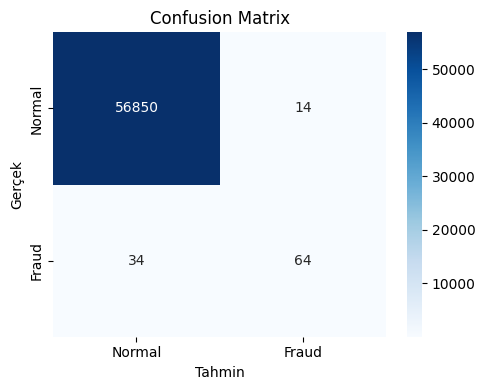

In [ ]:
X_2 = credit.drop(columns=['Class'])
y_2 = credit['Class']              

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42, stratify=y_2)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Bu modelin ger√ßekte i≈üe yaramamasƒ±nƒ±n sebebi bir sƒ±nƒ±ftan √ßok fazla olmasƒ±dƒ±r. Veri seti √∂zelliklerinde belirtildiƒüi gibi bu dengesiz bir veri setidir. Normal i≈ülemler √ßok fazla olduƒüu i√ßin model normal i≈ülemlere doƒüru bir y√∂nelme g√∂steriyor. Bu sebepten dolayƒ± da Fraud i≈ülemleri tahmin edemiyor. 

√á√∂z√ºm y√∂ntemlerine baktƒ±ƒüƒ±mda ise √∂n√ºme iki se√ßenek √ßƒ±ktƒ±. Undersampling yani √ßoƒüunluk sƒ±nƒ±f olan Normal i≈ülemleri azaltmak veya Oversampling yani azƒ±nlƒ±k sƒ±nƒ±f olan Fraud i≈ülemleri √ßoƒüaltmak. Ben burada veri kaybƒ± ya≈üamamak i√ßin Oversampling y√∂ntemini uygulamaya karar verdim.  

c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Accuracy: 0.9875
Precision: 0.1111
Recall: 0.8980
ROC-AUC: 0.9761


c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


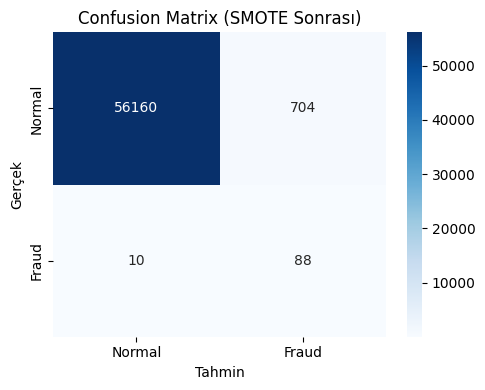

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
credit = pd.read_csv(url)

X = credit.drop(columns=['Class'])
y = credit['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.title("Confusion Matrix (SMOTE Sonrasƒ±)")
plt.tight_layout()
plt.show()


Oversampling uygulamak sonu√ßlarƒ± deƒüi≈ütirdi ancak hala tam olarak istediƒüim seviyede deƒüil. Yine de Fraud'larƒ± sayƒ± olarak doƒüru tahmin etme oranƒ± iyi bir derecede artmƒ±≈ü g√∂r√ºn√ºyor. Ancak bunda ≈ü√∂yle bir yanƒ±lgƒ±ya da d√º≈üebiliriz. Oversampling i≈ülemi yaptƒ±ktan sonra Precision metriƒüimiz olduk√ßa d√º≈üt√º. Confusion Matrix'ten de g√∂rebileceƒüimiz √ºzere modelin Fraud tahmin sayƒ±sƒ± bir hayli arttƒ± ve bunlar yanlƒ±≈ü tahminler. Yani model rastgele olarak Fraud tahmini de yapƒ±yor. Bu da istemediƒüimiz bir durum. Bu y√ºzden ben bu veri seti ve bu model √ºzerinde Oversampling y√∂ntemini ne ba≈üarƒ±lƒ± ne de ba≈üarƒ±sƒ±z buldum. 

c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

Accuracy: 0.9577
Precision: 0.0361
Recall: 0.9184
ROC-AUC: 0.9754


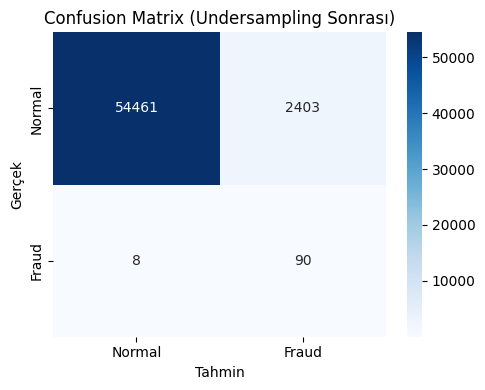

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
credit = pd.read_csv(url)

X = credit.drop(columns=['Class'])
y = credit['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
plt.xlabel("Tahmin")
plt.ylabel("Ger√ßek")
plt.title("Confusion Matrix (Undersampling Sonrasƒ±)")
plt.tight_layout()
plt.show()


Undersampling uygulamak sonu√ßlarƒ± neredeyse hi√ß deƒüi≈ütirmedi. Oversampling y√∂ntemiyle arasƒ±nda neredeyse fark yok. Hatta Undersampling SMOTE'un yaptƒ±ƒüƒ± hatalarƒ± daha da ileri bir seviyede yaptƒ±.


üîç Model: Random Forest
Accuracy : 0.9996
Precision: 0.9412
Recall   : 0.8163
ROC-AUC  : 0.9630


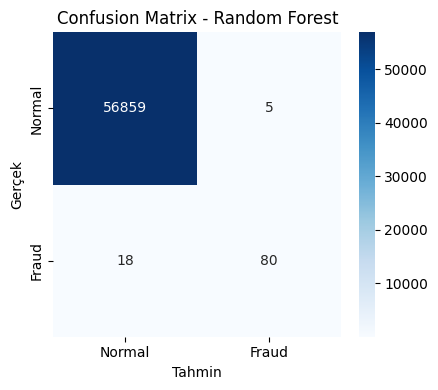


üîç Model: XGBoost


c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [20:16:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy : 0.9995
Precision: 0.9186
Recall   : 0.8061
ROC-AUC  : 0.9743


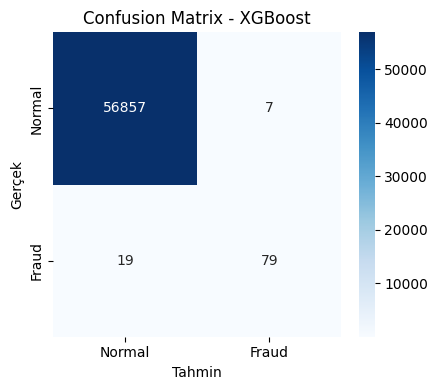


üîç Model: KNN
Accuracy : 0.9983
Precision: 1.0000
Recall   : 0.0306
ROC-AUC  : 0.6364


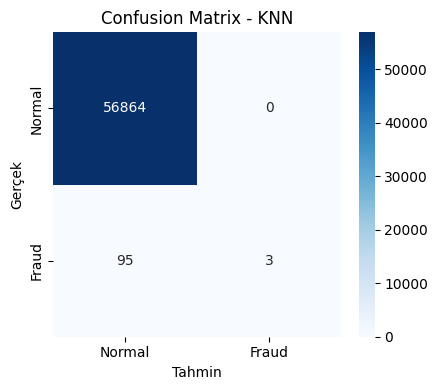


üîç Model: SVM
Accuracy : 0.9983
Precision: 0.0000
Recall   : 0.0000
ROC-AUC  : 0.4037


c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


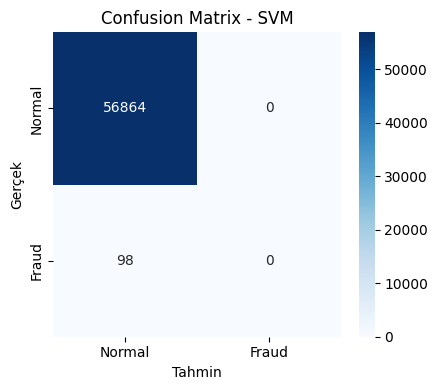

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
credit = pd.read_csv(url)

X = credit.drop(columns=['Class'])
y = credit['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(probability=True, random_state=42)
}

for name, model in models.items():
    print(f"\nüîç Model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")

    plt.figure(figsize=(4.5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
    plt.xlabel("Tahmin")
    plt.ylabel("Ger√ßek")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

Bu modeller arasƒ±nda en doƒüru sonucu Random Forest ve XGBoost modelleri verdi. SVM modeli tamamƒ±na Normal i≈ülem, K-NN modeli ise neredeyse tamamƒ±na yakƒ±nƒ±na Normal i≈ülem dedi. Bu y√ºzden de Precision ve Recall deƒüerleri 0 ve 0'a √ßok yakƒ±n √ßƒ±ktƒ±. Random Forest ile XGBoost ise Regresyon modellerine g√∂re daha iyi sonu√ßlar verdi. 
A√ßƒ±k√ßasƒ± Lecture 9'dan Random Forest ve XGBoost modellerini ara≈ütƒ±rdƒ±ƒüƒ±mda b√∂yle bir sonu√ß bekliyordum. Temel mantƒ±klarƒ± bu veri setine uyuyor gibi gelmi≈üti bana. Beklediƒüim gibi de bir sonu√ß √ßƒ±ktƒ±. Bu iki model tam anlamƒ±yla olmasa da sorunumuzu √ß√∂zd√º diyebiliriz.